# Fine Tuning For BERT Models with TPU

In [1]:
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

In [2]:
import tensorflow as tf
import os

# Note that the `tpu` argument is for Colab-only
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [3]:
strategy = tf.distribute.TPUStrategy(resolver)

## Import Library

In [4]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

import sys
np.set_printoptions(threshold=sys.maxsize)

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
tf.__version__

'2.8.2'

### **Getting Data for Intent Classification**

The data contains various user queries categorized into seven 

https://github.com/sonos/nlu-benchmark/tree/master/2017-06-custom-intent-enginesintents

In [5]:
!gdown 1OlcvGWReJMuyYQuOZm149vHWwPtlboR6 --output train.csv
!gdown 1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w --output valid.csv
!gdown 1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF --output test.csv

Downloading...
From: https://drive.google.com/uc?id=1OlcvGWReJMuyYQuOZm149vHWwPtlboR6
To: /content/train.csv
100% 799k/799k [00:00<00:00, 30.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w
To: /content/valid.csv
100% 43.3k/43.3k [00:00<00:00, 2.96MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF
To: /content/test.csv
100% 43.1k/43.1k [00:00<00:00, 29.4MB/s]


In [6]:
train = pd.read_csv("train.csv")
valid = pd.read_csv("valid.csv")
test = pd.read_csv("test.csv")

In [7]:
train.head()

,text,intent
0,listen to westbam alumb allergic on google music,PlayMusic
1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,i give this current textbook a rating value of...,RateBook
3,play the song little robin redbreast,PlayMusic
4,please add iris dement to my playlist this is ...,AddToPlaylist


In [8]:
print('Train data size      -->', train.shape)
print('Validation data size -->', valid.shape)
print('Test data size       -->', test.shape)

Train data size      --> (13084, 2)
Validation data size --> (700, 2)
Test data size       --> (700, 2)


In [ ]:
#### Combining train and validation data

In [9]:
train = train.append(valid).reset_index(drop=True)

In [10]:
train.shape

(13784, 2)

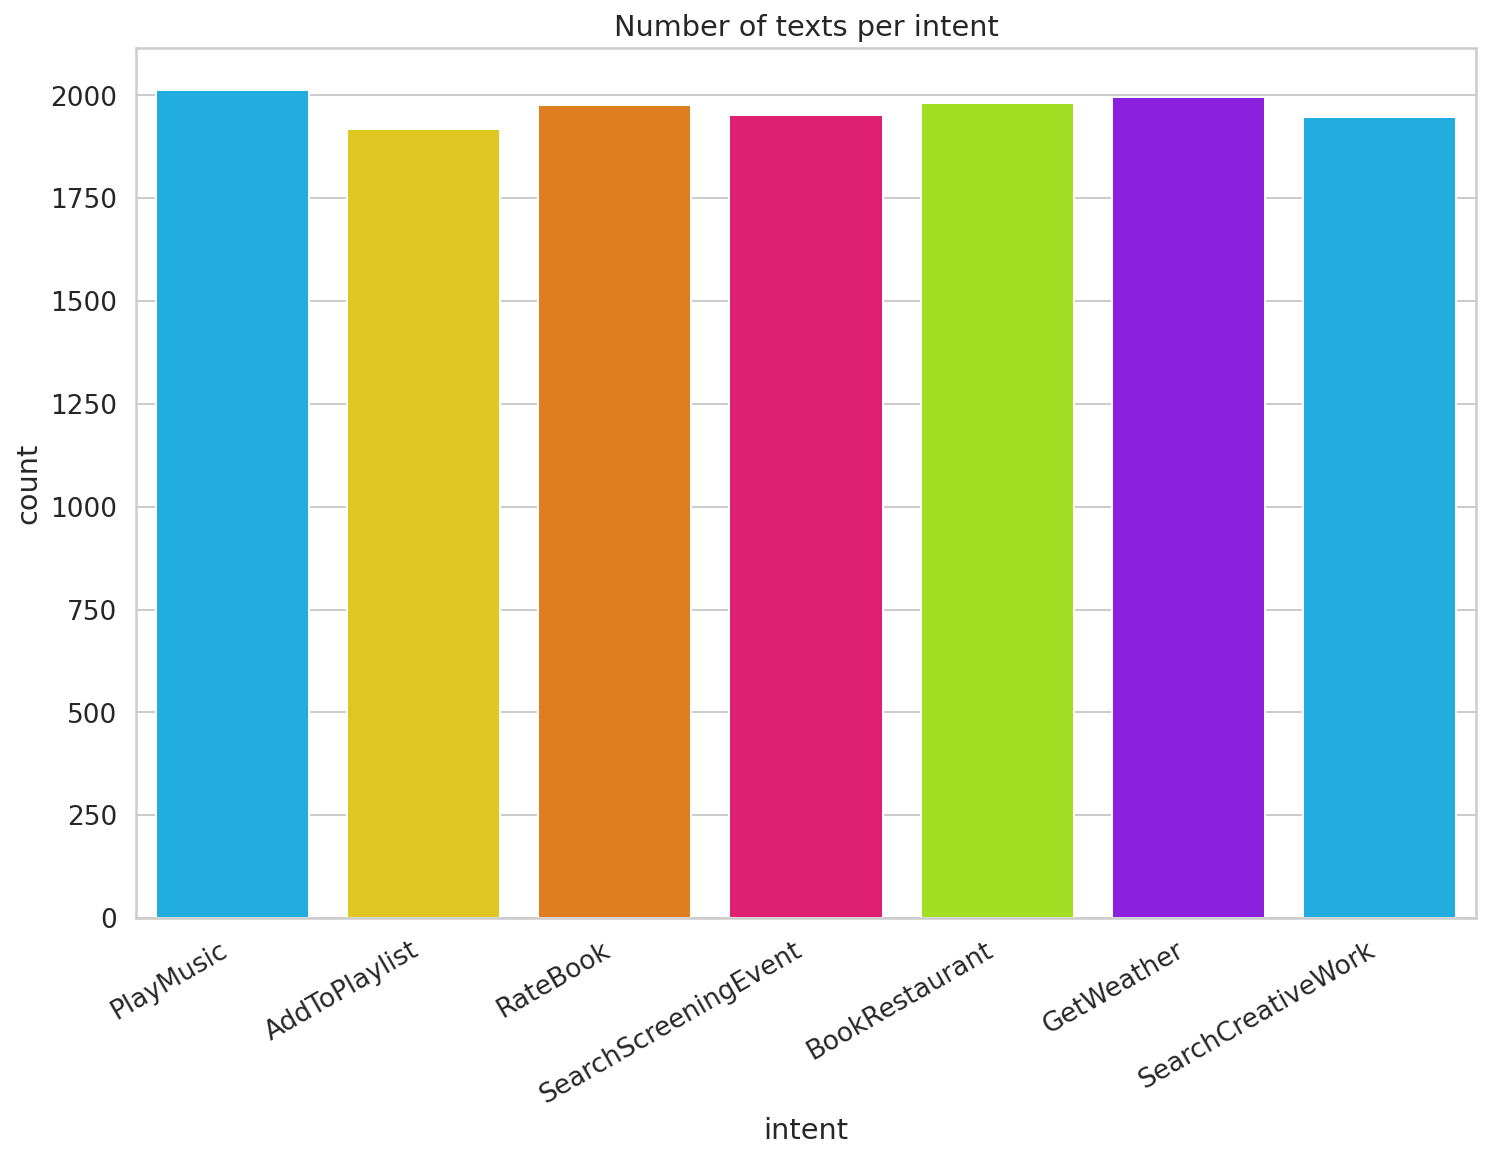

In [ ]:
chart = sns.countplot(train.intent, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

In [11]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 7.9 MB/s eta 0:00:00


### Tokenization

In [12]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [14]:
tokenizer.vocab

OrderedDict([('[PAD]', 0),
             ('[unused1]', 1),
             ('[unused2]', 2),
             ('[unused3]', 3),
             ('[unused4]', 4),
             ('[unused5]', 5),
             ('[unused6]', 6),
             ('[unused7]', 7),
             ('[unused8]', 8),
             ('[unused9]', 9),
             ('[unused10]', 10),
             ('[unused11]', 11),
             ('[unused12]', 12),
             ('[unused13]', 13),
             ('[unused14]', 14),
             ('[unused15]', 15),
             ('[unused16]', 16),
             ('[unused17]', 17),
             ('[unused18]', 18),
             ('[unused19]', 19),
             ('[unused20]', 20),
             ('[unused21]', 21),
             ('[unused22]', 22),
             ('[unused23]', 23),
             ('[unused24]', 24),
             ('[unused25]', 25),
             ('[unused26]', 26),
             ('[unused27]', 27),
             ('[unused28]', 28),
             ('[unused29]', 29),
             ('[unused30]', 30),
 

In [16]:
print(len(tokenizer.vocab))

28996


In [13]:
tokenizer2 = BertTokenizer.from_pretrained('bert-base-uncased')

In [17]:
print(len(tokenizer2.vocab))

30522


In [ ]:
text = "Careless driver and student ended up with some hospitalization 🏥." 
print(tokenizer.tokenize(text))

['Care', '##less', 'driver', 'and', 'student', 'ended', 'up', 'with', 'some', 'hospital', '##ization', '[UNK]', '.']


In [ ]:
text = "Careless driver and student ended up with some hospitalization 🏥." 
print(tokenizer2.tokenize(text))

['careless', 'driver', 'and', 'student', 'ended', 'up', 'with', 'some', 'hospital', '##ization', '[UNK]', '.']


In [ ]:
[SEP] [CLS] [PAD]

In [ ]:
input_ids = tokenizer.encode(text)
print(input_ids)

[101, 8396, 2008, 3445, 1105, 2377, 2207, 1146, 1114, 1199, 2704, 2734, 100, 119, 102]


In [ ]:
print(tokenizer.convert_tokens_to_ids(['Care', '##less', 'driver', 'and', 'student', 'ended', 'up', 'with', 'some', 'hospital', '##ization', '.']))

[8396, 2008, 3445, 1105, 2377, 2207, 1146, 1114, 1199, 2704, 2734, 119]


In [ ]:
print(tokenizer.convert_tokens_to_string(['Care', '##less', 'driver', 'and', 'student', 'ended', 'up', 'with', 'some', 'hospital', '##ization', '.']))

Careless driver and student ended up with some hospitalization .


In [ ]:
tokenizer.decode(input_ids)

'[CLS] Careless driver and student ended up with some hospitalization [UNK]. [SEP]'

In [ ]:
input_ids = tokenizer.encode(text)
print(input_ids)
print(tokenizer.encode_plus(text))

[101, 8396, 2008, 3445, 1105, 2377, 2207, 1146, 1114, 1199, 2704, 2734, 100, 119, 102]
{'input_ids': [101, 8396, 2008, 3445, 1105, 2377, 2207, 1146, 1114, 1199, 2704, 2734, 100, 119, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
tokenizer.encode_plus(text).keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
print(tokenizer.encode_plus(text)['input_ids'])

[101, 8396, 2008, 3445, 1105, 2377, 2207, 1146, 1114, 1199, 2704, 2734, 100, 119, 102]


In [ ]:
max_len = 0

# For every sentence...
max_token = []
for i, review in enumerate(train['text']):
    
    input_ids = tokenizer.encode(review.lower(), add_special_tokens=True)

    max_token.append(len(input_ids))
    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  43


In [ ]:
list = [5, 10, 8, 9, 12, 15]
print(np.array(list) < 10)
print(sum(np.array(list) < 10))

[ True False  True  True False False]
3


In [ ]:

np.array(max_token).mean()

13.078351712130006

In [ ]:
token_size = 40
sum(np.array(max_token) < token_size) / len(max_token)

0.9998549042367962

In [ ]:
number_samples = 3
seq_length = 5
Xids_ = np.zeros((number_samples, seq_length))
Xids_

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [ ]:
def transformation(X, seq_len=512):
  # set array dimensions
  if seq_len < 0 or seq_len > 512:
    seq_len = 512
  num_samples = len(X)

  # initialize empty zero arrays
  Xids = np.zeros((num_samples, seq_len))
  Xmask = np.zeros((num_samples, seq_len))

  for i, text in enumerate(X):
      # Special Tokens --> [CLS], [SEP], [PAD]
      tokens = tokenizer.encode_plus(text.lower(), max_length=seq_len, truncation=True,
                                     padding='max_length', add_special_tokens=True,
                                     return_tensors='tf') # tensorflow --> tf, pytorch --> pt) 
      # assign tokenized outputs to respective rows in numpy arrays
      Xids[i, :] = tokens['input_ids']
      Xmask[i, :] = tokens['attention_mask'] # BERT will calculate the attention for the tokens with 1 in mask, otherwise no calculation
  return Xids, Xmask, seq_len

In [ ]:
Xids, Xmask, seq_len = transformation(train['text'], seq_len=max_len)

In [ ]:
Xids[0, :]

array([  101.,  5113.,  1106.,  1745.,  2822.,  1306.,  2393.,  1818.,
        1830.,  1155., 26949.,  1113.,  1301.,  8032.,  1513.,  1390.,
         102.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0.,     0.])

In [ ]:
Xmask[0]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

#### Converting Labels to Numeric Form

In [ ]:
unique_labels = train['intent'].unique()
unique_labels

array(['PlayMusic', 'AddToPlaylist', 'RateBook', 'SearchScreeningEvent',
       'BookRestaurant', 'GetWeather', 'SearchCreativeWork'], dtype=object)

In [ ]:
label_dict = dict()
lbl_array = train['intent'].values
for i, label in enumerate(unique_labels):
    label_dict[label] = i

In [ ]:
label_dict

{'PlayMusic': 0,
 'AddToPlaylist': 1,
 'RateBook': 2,
 'SearchScreeningEvent': 3,
 'BookRestaurant': 4,
 'GetWeather': 5,
 'SearchCreativeWork': 6}

In [ ]:
train['label_code'] = train['intent'].map(label_dict)

In [ ]:
train.head()

,text,intent,label_code
0,listen to westbam alumb allergic on google music,PlayMusic,0
1,add step to me to the 50 clásicos playlist,AddToPlaylist,1
2,i give this current textbook a rating value of...,RateBook,2
3,play the song little robin redbreast,PlayMusic,0
4,please add iris dement to my playlist this is ...,AddToPlaylist,1


In [ ]:
test['label_code'] = test['intent'].map(label_dict)

#### One-Hot_Encoding The Labels

In [ ]:
max_intent_no = max(train['label_code'])
labels_trn = np.zeros((len(train['intent']), max_intent_no+1))
labels_trn[np.arange(len(train['intent'])), train['label_code']] = 1
labels_trn

array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
 

In [ ]:
labels_tst = np.zeros((len(test['intent']), max_intent_no+1))
labels_tst[np.arange(len(test['intent'])), test['label_code']] = 1
labels_tst

array([[0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
 

In [ ]:
labels_trn.shape, labels_tst.shape

((13784, 7), (700, 7))

In [ ]:
dataset_trn = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels_trn)) #tf.data.Dataset.from_tensors((Xids, Xmask, labels))
dataset_trn

<TensorSliceDataset element_spec=(TensorSpec(shape=(43,), dtype=tf.float64, name=None), TensorSpec(shape=(43,), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.float64, name=None))>

In [ ]:
labels_trn[0]

array([1., 0., 0., 0., 0., 0., 0.])

In [ ]:
dataset_trn.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(43,), dtype=tf.float64, name=None), TensorSpec(shape=(43,), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.float64, name=None))>

In [ ]:
batch_size = 32 #16

leng= len(Xids)

# shuffle and batch
# fit into a batch of 32
dataset_trn_batch = dataset_trn.shuffle(buffer_size=leng, reshuffle_each_iteration=False).batch(batch_size, drop_remainder=True)
dataset_trn_batch

<BatchDataset element_spec=(TensorSpec(shape=(32, 43), dtype=tf.float64, name=None), TensorSpec(shape=(32, 43), dtype=tf.float64, name=None), TensorSpec(shape=(32, 7), dtype=tf.float64, name=None))>

### Preparing Test Set

In [ ]:
# Validation_set
Xids_tst, Xmask_tst, seq_len_tst = transformation(test['text'], seq_len=max_len)

In [ ]:
dataset_tst = tf.data.Dataset.from_tensor_slices((Xids_tst, Xmask_tst, labels_tst)) #tf.data.Dataset.from_tensors((Xids, Xmask, labels))
dataset_tst

<TensorSliceDataset element_spec=(TensorSpec(shape=(43,), dtype=tf.float64, name=None), TensorSpec(shape=(43,), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.float64, name=None))>

In [ ]:
dataset_tst.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(43,), dtype=tf.float64, name=None), TensorSpec(shape=(43,), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.float64, name=None))>

In [ ]:
batch_size = 32 #16

leng= len(Xids_tst)

# shuffle and batch
# fit into a batch of 32
dataset_tst_batch = dataset_tst.shuffle(buffer_size=leng, reshuffle_each_iteration=False).batch(batch_size, drop_remainder=True)

In [ ]:
dataset_tst_batch

<BatchDataset element_spec=(TensorSpec(shape=(64, 43), dtype=tf.float64, name=None), TensorSpec(shape=(64, 43), dtype=tf.float64, name=None), TensorSpec(shape=(64, 7), dtype=tf.float64, name=None))>

In [ ]:
def map_func(Xids, Xmask, labels):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': Xids, 'attention_mask': Xmask}, labels

# then we use the dataset map method to apply this transformation
dataset_trn_dict = dataset_trn_batch.map(map_func)
dataset_tst_dict = dataset_tst_batch.map(map_func)

In [ ]:
dataset_trn_dict.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(32, 43), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(32, 43), dtype=tf.float64, name=None)}, TensorSpec(shape=(32, 7), dtype=tf.float64, name=None))>

In [ ]:
dataset_tst_dict.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(32, 43), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(32, 43), dtype=tf.float64, name=None)}, TensorSpec(shape=(32, 7), dtype=tf.float64, name=None))>

In [ ]:
# If we had Binary Labels and then we might use the below approach for labels 

In [ ]:
# from tensorflow.keras.utils import to_categorical

# l = np.array([0, 1])
# to_categorical(l, 2)

In [ ]:
# np.array([1, 0, 1, 0, 0]).reshape(-1,1) 

### Train-Test Split --> For Other Problems

We will not be using tain test split but for other problems nice to have here.

In [ ]:
batch_size = 64

leng = len(Xids)

# shuffle and batch
# fit into a batch of 32
dataset = dataset_trn_dict.shuffle(buffer_size=leng, reshuffle_each_iteration=False).batch(batch_size, drop_remainder=True)

In [ ]:
#batch_size=32
int(Xids.shape[0]/batch_size)

215

In [ ]:
print('total batch size -->', len(dataset_trn))
print('train batch size -->', len(dataset_trn)*0.9)
print('int batch size   -->', int(len(dataset_trn)*0.9))

total batch size --> 13784
train batch size --> 12405.6
int batch size   --> 12405


In [ ]:
# # set split size (90% training data) and calculate training set size
# split = 0.9
# size = int(len(dataset)*split) #int((Xids.shape[0]/batch_size)*split)

# # get training and validation sets
# train_ds = dataset.take(size)
# val_ds = dataset.skip(size)

### Creating the Model

In [ ]:
from transformers import TFAutoModel, BertModel
bert_model = TFAutoModel.from_pretrained("bert-base-cased")

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
bert_model2 = BertModel.from_pretrained("bert-base-cased")

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
bert_model.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [ ]:
seq_len

43

In [ ]:
train_ds = dataset_trn_dict
val_ds = dataset_tst_dict

In [ ]:
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
attention_mask = tf.keras.layers.Input(shape=(seq_len, ), name='attention_mask', dtype='int32')

In [ ]:
embeddings = bert_model.bert(input_ids=input_ids, attention_mask=attention_mask)

In [ ]:
embeddings#[1]#["pooler_output"]

TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<KerasTensor: shape=(None, 43, 768) dtype=float32 (created by layer 'bert')>, pooler_output=<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'bert')>, past_key_values=None, hidden_states=None, attentions=None, cross_attentions=None)

In [ ]:
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
attention_mask = tf.keras.layers.Input(shape=(seq_len, ), name='attention_mask', dtype='int32')

embeddings = bert_model.bert(input_ids=input_ids, attention_mask=attention_mask)["pooler_output"]

x = tf.keras.layers.Dense(256, activation='relu')(embeddings)
x= tf.keras.layers.Dropout(0.1, name="dropout")(x)
y = tf.keras.layers.Dense(max_intent_no+1, activation='softmax', name='outputs')(x)

In [ ]:
model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=y)

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=2e-5)#, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')
#model = create_model()
model.compile(optimizer=optimizer,
            loss=loss, 
            metrics=[acc])

In [ ]:
history = model.fit(train_ds,
                   validation_data=val_ds,
                   epochs=1,
                   callbacks=[early_stop])

430/430 [==============================] - 399s 897ms/step - loss: 0.2026 - accuracy: 0.9440 - val_loss: 0.0666 - val_accuracy: 0.9836


In [ ]:
# model = tf.keras.Model(inputs=[input_ids, masks], outputs=y)
# model2 = tf.keras.Model(inputs=[input_ids, masks], outputs=y)

In [ ]:
# Optional
# model2.layers[2].trainable = False # From the model summary below, 2nd layer is BertLayer

In [ ]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 43)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 43)]         0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 43,                                          

### Compiling the Model

In [ ]:
def create_model():
    from transformers import TFAutoModel
    model = TFAutoModel.from_pretrained("bert-base-cased")
    input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
    attention_mask = tf.keras.layers.Input(shape=(seq_len, ), name='attention_mask', dtype='int32')

    embeddings = model.bert(input_ids=input_ids, attention_mask=attention_mask)["pooler_output"] #[1]

    x = tf.keras.layers.Dense(256, activation='relu')(embeddings)
    x = tf.keras.layers.Dropout(0.1, name="dropout")(x) #0.1
    y = tf.keras.layers.Dense(7, activation='softmax', name='outputs')(x)

    return tf.keras.Model(inputs=[input_ids, attention_mask], outputs=y)

In [ ]:
with strategy.scope():
  
    optimizer = tf.keras.optimizers.Adam(lr=2e-5)#, decay=1e-6)
    loss = tf.keras.losses.CategoricalCrossentropy()
    acc = tf.keras.metrics.CategoricalAccuracy('accuracy')
    model = create_model()
    model.compile(optimizer=optimizer,
              loss=loss, 
              metrics=[acc])

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
history = model.fit(train_ds,
                   validation_data=val_ds,
                   epochs=2)

Epoch 1/2
430/430 [==============================] - 96s 75ms/step - loss: 0.2154 - accuracy: 0.9395 - val_loss: 0.0738 - val_accuracy: 0.9792
Epoch 2/2
430/430 [==============================] - 27s 62ms/step - loss: 0.0327 - accuracy: 0.9909 - val_loss: 0.0778 - val_accuracy: 0.9747


----

### Model Evaluation

In [ ]:
# for i in val_ds:
#     print(np.array(i[1]))
#     print('----')

In [ ]:
test['label_code']

0      1
1      4
2      1
3      5
4      0
      ..
695    6
696    6
697    2
698    1
699    2
Name: label_code, Length: 700, dtype: int64

In [ ]:
preds[0]

array([1.9617027e-04, 1.8628658e-04, 8.2885257e-05, 1.0180364e-04,
       9.9754697e-01, 1.7927050e-03, 9.3287934e-05], dtype=float32)

In [ ]:
for i in preds:
    print(max(i))

0.997547
0.99810684
0.9980279
0.999696
0.99905497
0.99828917
0.9983241
0.9991753
0.9970066
0.9956221
0.999198
0.999689
0.99907273
0.9978959
0.9990349
0.9977344
0.99935347
0.9908161
0.9991547
0.9967007
0.9990995
0.9962287
0.99900705
0.99871266
0.99794954
0.9973026
0.9994037
0.9709164
0.9990765
0.99910647
0.99816304
0.99927026
0.99935263
0.8984432
0.9977223
0.99940515
0.9992823
0.9994704
0.9970817
0.9991799
0.9973175
0.9988335
0.9987631
0.99749774
0.9980165
0.99758196
0.9989968
0.9995546
0.9992706
0.9986461
0.9982097
0.99912566
0.9951696
0.9953524
0.9946431
0.9988913
0.9959735
0.9992293
0.9992892
0.9987342
0.99949074
0.99909484
0.9993005
0.80836296
0.9990994
0.9974739
0.9918902
0.9992773
0.8246556
0.9993444
0.9995221
0.9991636
0.99734086
0.99803656
0.9965592
0.9994936
0.9980209
0.9992085
0.99944097
0.9978248
0.9984397
0.99723154
0.99914634
0.9971634
0.9956132
0.99799085
0.99918133
0.99848145
0.99912816
0.99835914
0.99949276
0.99865204
0.997288
0.99483395
0.9974723
0.9992568
0.9973315
0.9

In [ ]:
preds = model.predict(val_ds)
preds

array([[1.06828287e-04, 3.83932238e-05, 4.72033898e-05, 7.58803217e-05,
        9.98172283e-01, 1.48965430e-03, 6.97393843e-05],
       [9.98289406e-01, 6.64127117e-04, 1.51618879e-04, 1.99706948e-04,
        2.35225787e-04, 2.83443514e-04, 1.76366666e-04],
       [1.39413125e-04, 4.91465617e-05, 5.64660295e-05, 1.98144495e-04,
        9.97441292e-01, 2.02186615e-03, 9.36409051e-05],
       [5.30476427e-05, 9.99585092e-01, 5.32771337e-05, 7.40183896e-05,
        3.93265545e-05, 1.39851705e-04, 5.54208091e-05],
       [7.60411669e-04, 1.69541672e-04, 3.27600283e-04, 1.12486239e-04,
        2.25779819e-04, 2.09358303e-04, 9.98194873e-01],
       [1.02972990e-04, 4.27258783e-05, 1.07016065e-04, 9.99470651e-01,
        1.40482938e-04, 4.76584610e-05, 8.85743357e-05],
       [7.27935330e-05, 4.04224083e-05, 1.02896709e-04, 9.99496102e-01,
        1.61999953e-04, 5.50787991e-05, 7.06486971e-05],
       [1.06611093e-04, 7.41692784e-05, 4.10974135e-05, 7.00414748e-05,
        6.88736982e-05, 9

In [ ]:
for i in preds:
    try:
        y_pred = preds[i] == max(i)
        print(y_pred)
    except:
        pass


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(val_ds) >= 0.5 # There can't be 2 probabilities both are greater than 0.5, so returns the max prob
#preds = model.predict(val_ds)
for i in preds:
    try:
        y_pred = preds[i] == max(i)
    except:
        pass

y_test = []
for i in val_ds:
  for j in np.array(i[1]):
    y_test.append(j)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        81
           1       1.00      1.00      1.00       121
           2       1.00      1.00      1.00        78
           3       0.95      0.94      0.95       106
           4       0.98      1.00      0.99        86
           5       1.00      0.99      0.99       100
           6       0.95      0.90      0.92       100

   micro avg       0.97      0.97      0.97       672
   macro avg       0.97      0.98      0.97       672
weighted avg       0.97      0.97      0.97       672
 samples avg       0.97      0.97      0.97       672



In [ ]:
# For Binary Classification

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

y_pred_proba = model.predict(val_ds)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot([1,0],[0,1],'k--')
plt.plot(recall, precision)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('precision recall curve')
plt.show()

### Saving the Model

In [ ]:
model.save("/content/drive/MyDrive/intent_classifier_model.h5")

In [ ]:
from tensorflow.keras.models import load_model
from google.colab import drive
drive.mount('/content/drive')
model_new = load_model('/content/drive/MyDrive/intent_classifier_model.h5')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model_new.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 43)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 43)]         0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 43,                                          

In [ ]:
# initialize tokenizer from transformers
from transformers import AutoTokenizer, TFAutoModel, BertTokenizer

#tokenizers = AutoTokenizer.from_pretrained("bert-base-cased")
tokenizers = BertTokenizer.from_pretrained('bert-base-cased')

def prep_data(text):
    # tokenize to get input IDs and attention mask tensors
    tokens = tokenizers.encode_plus(text.lower(), max_length=43,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True,
                                   return_tensors='tf')
  
    return {'input_ids': tokens['input_ids'],      #tf.cast(tokens['input_ids'], tf.int32)
            'attention_mask': tokens['attention_mask']} #tf.cast(tokens['attention_mask'], tf.int32)

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
prep_data('Hello world')

{'input_ids': <tf.Tensor: shape=(1, 43), dtype=int32, numpy=
 array([[  101, 19082,  1362,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=int32)>,
 'attention_mask': <tf.Tensor: shape=(1, 43), dtype=int32, numpy=
 array([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       dtype=int32)>}

In [ ]:
train.head(10)

,text,intent,label_code
0,listen to westbam alumb allergic on google music,PlayMusic,3
1,add step to me to the 50 clásicos playlist,AddToPlaylist,2
2,i give this current textbook a rating value of...,RateBook,5
3,play the song little robin redbreast,PlayMusic,3
4,please add iris dement to my playlist this is ...,AddToPlaylist,2
5,add slimm cutta calhoun to my this is prince p...,AddToPlaylist,2
6,i want to listen to seventies music,PlayMusic,3
7,play a popular chant by brian epstein,PlayMusic,3
8,find fish story,SearchScreeningEvent,6
9,book a spot for 3 in mt,BookRestaurant,0


In [ ]:
text1 = "please play the most popular songs"
text2 = "I will give 0 star to the book I am reading now"
text3 = "Find me the best movies"
text4 = "I'd like to watch the best actor movie"
text5 = "Need to make a reservation for 4."

reviews = [text1, text2, text3, text4, text5]

In [ ]:
probs = []
for i in reviews:

  in_tensor = prep_data(i)

  prob = model_new.predict(in_tensor)[0]

  probs.append(prob)

In [ ]:
in_tensor

{'input_ids': <tf.Tensor: shape=(1, 43), dtype=int32, numpy=
 array([[  101,  1444,  1106,  1294,   170, 15702,  1111,   125,   119,
           102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=int32)>,
 'attention_mask': <tf.Tensor: shape=(1, 43), dtype=int32, numpy=
 array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       dtype=int32)>}

In [ ]:
probs

[array([1.3583298e-03, 4.2302388e-01, 1.9393661e-03, 5.7001579e-01,
        5.5425166e-04, 7.6810509e-04, 2.3401869e-03], dtype=float32),
 array([0.00280793, 0.10381569, 0.00146137, 0.00156295, 0.11020678,
        0.7626921 , 0.01745319], dtype=float32),
 array([1.1366514e-04, 6.3249585e-03, 3.5716695e-04, 1.8530559e-04,
        1.8998604e-04, 1.2195001e-04, 9.9270695e-01], dtype=float32),
 array([1.2406738e-03, 9.3024862e-01, 8.3890882e-05, 7.2308705e-04,
        1.0983613e-03, 4.0171464e-04, 6.6203505e-02], dtype=float32),
 array([9.9622107e-01, 2.3818384e-03, 3.7175042e-04, 3.5267434e-04,
        3.4338661e-04, 9.1453170e-05, 2.3786025e-04], dtype=float32)]

In [ ]:
label_dict

{'BookRestaurant': 0,
 'SearchCreativeWork': 1,
 'AddToPlaylist': 2,
 'PlayMusic': 3,
 'GetWeather': 4,
 'RateBook': 5,
 'SearchScreeningEvent': 6}

In [ ]:
index_to_label = dict()

for k, v in label_dict.items():
    index_to_label[v] = k

index_to_label

{0: 'BookRestaurant',
 1: 'SearchCreativeWork',
 2: 'AddToPlaylist',
 3: 'PlayMusic',
 4: 'GetWeather',
 5: 'RateBook',
 6: 'SearchScreeningEvent'}

In [ ]:
classes = []
probas = []
for idx in range(len(reviews)):
    classes.append(index_to_label[np.argmax(probs[idx])])
    probas.append(max(probs[idx]))

In [ ]:
my_dict = {"Review":reviews, "prob":probas, "classes":classes}

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.DataFrame(my_dict)

,Review,prob,classes
0,please play the most popular songs,0.570016,PlayMusic
1,I will give 0 star to the book I am reading now,0.762692,RateBook
2,Find me the best movies,0.992707,SearchScreeningEvent
3,I'd like to watch the best actor movie,0.930249,SearchCreativeWork
4,Need to make a reservation for 4.,0.996221,BookRestaurant
